## PAW wavelet clustering

In [3]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [4]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from matplotlib import pyplot as plt
from scipy import stats
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Get my functions
from functions import idxs_from_files, plot_kde, GMM_neg_log_likelihood

one = ONE(mode='remote')

In [5]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
velocity = True

path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
super_session = np.load(path+'supersession_wavelets_paw09-12-2025')

paw_states_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_most_likely_states/'


In [6]:
paws = ['l_paw',  'r_paw']
var_init = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 'l_paw_x16.0', 'l_paw_x32.0',
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 'l_paw_y16.0', 'l_paw_y32.0',
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 'r_paw_x16.0', 'r_paw_x32.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0', 'r_paw_y16.0', 'r_paw_y32.0']
var_interest = var_init[4:]

# Wavelet clustering

In [7]:
df = pd.DataFrame(super_session, columns=var_init)
use_vars = var_interest
use_data = np.array(df[var_interest])
zscore = True

if zscore:
    data = np.array(stats.zscore(use_data, axis=0))
else:
    X_centered = use_data - np.mean(use_data, axis=0)
    data = np.array(use_data)

use_data = data.copy()

# Find best k

### Inertia

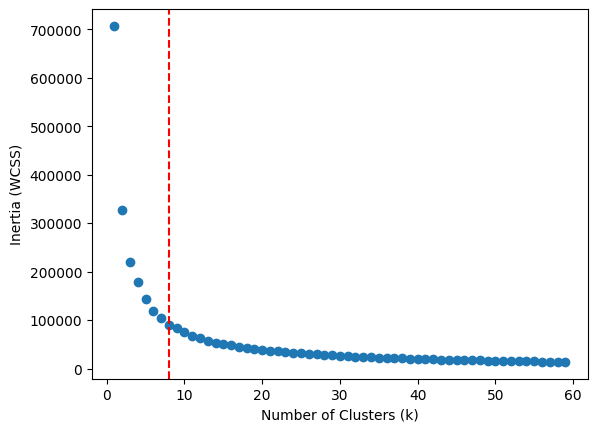

In [8]:

inertia_values = []
K = range(1, 60)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(use_data)[0]*0.8)
    X_train = np.vstack([use_data[:cutoff, 0], use_data[:cutoff, 1]]).T
    kmeans.fit(X_train.copy())
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.savefig(save_path+'inertia_values_session_part_clusters.svg', format="svg")

plt.show()

In [9]:
print(optimal_k)

8


# kMeans on supersession

In [130]:
# optimal_k = 8

kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(use_data.copy())
centroids = kmeans.cluster_centers_
cluster_values = kmeans.predict(use_data)

In [132]:
# Loop through animals
sessions_to_process = []

for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]

    sessions_to_process.append((mouse_name, session))

In [136]:
if velocity:
    subname = "paw_vel_wavelets_"
else:
    subname = "paw_pos_wavelets_"
assert len(sessions_to_process) == 218
for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    filename = wavelet_path + subname + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    var_array = np.array(design_matrix[use_vars].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    mouse_data = stats.zscore(var_array[not_nan, :], axis=0, nan_policy='omit')
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(mouse_data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    
    design_matrix['paw_states'] = np.nan
    design_matrix['paw_states'][not_nan] = states
    
    """ Save paw states on design_matrix """

    # Save most_likely_states
    filename = paw_states_path + "most_likely_states" + '_'+str(optimal_k)+'_'+ str(mouse_name+session)
    np.save(filename, states)
    # Save most_likely_states
    filename = paw_states_path + "centroid_distances" + '_'+str(optimal_k)+'_'+ str(mouse_name+session)
    np.save(filename, distances)


/tmp/ipykernel_12321/353983736.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_12321/353983736.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice